# Exercise 5 - Code

*Compare three real-world datasets:*

- *Protein Edgelist*
- *Collaboration Edgelist*
- *Powergrid Edgelist*

In [1]:
import networkx as nx
import numpy as np
from scipy.stats import expon, powerlaw
from matplotlib import pyplot as plt

plt.rcdefaults()
plt.style.use("seaborn")
plt.rc("figure", figsize=(11.2, 6.3))
plt.rc("font", size=12)

path = "../data/"

networks = {
    "Protein Network" : nx.read_edgelist(path + "protein.edgelist.txt"),
    "Collaboration Network" : nx.read_edgelist(path + "collaboration.edgelist.txt"),
    "Powergrid Network" : nx.read_edgelist(path + "powergrid.edgelist.txt")
}

*1. Plot the cumulative degree distribution for each network.*

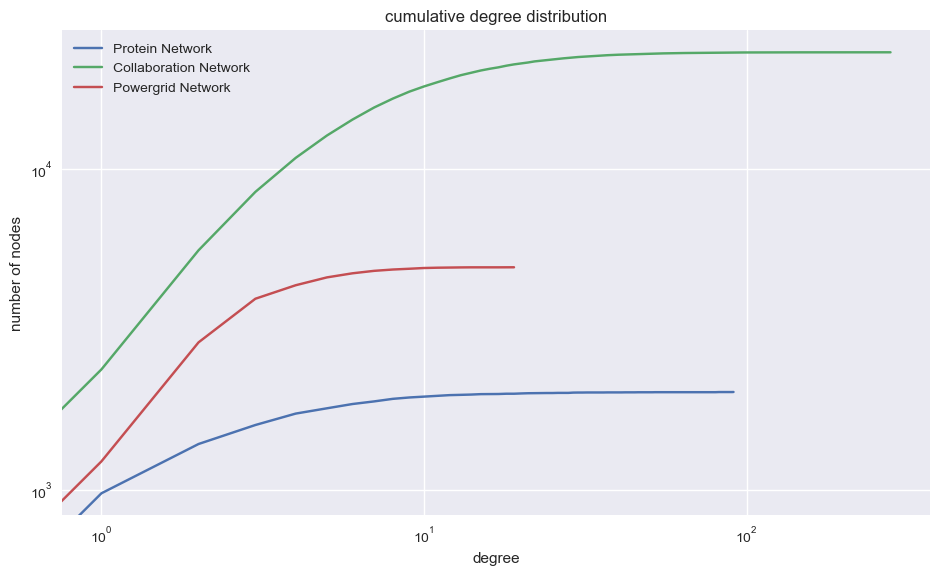

In [2]:
for name, network in networks.items():
    degrees = nx.degree_histogram(network)
    plt.loglog(np.arange(len(degrees)), np.cumsum(degrees), label=name)

plt.legend()
plt.title("cumulative degree distribution")
plt.xlabel("degree")
plt.ylabel("number of nodes")
plt.show()

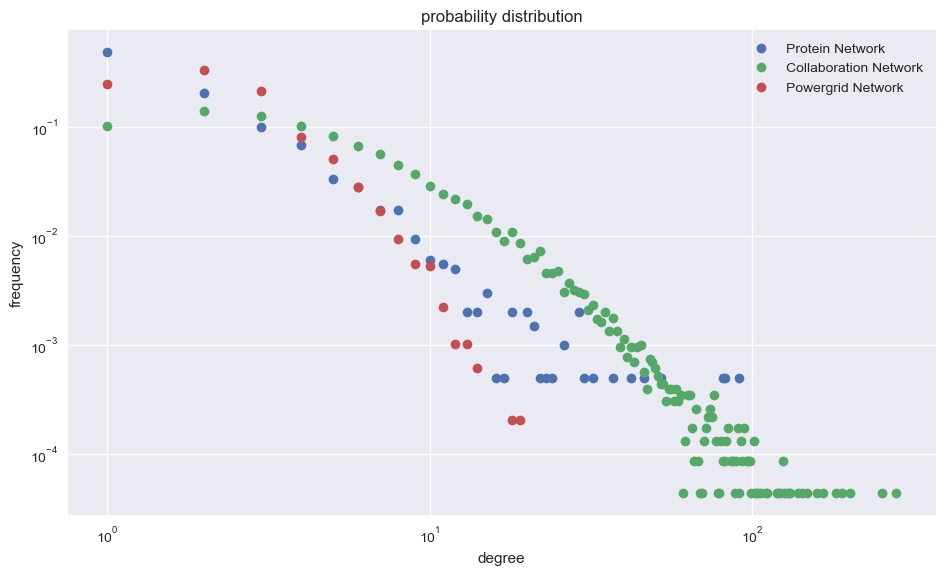

In [3]:
for name, network in networks.items():
    frequencies = np.array(nx.degree_histogram(network)) / len(network)
    plt.loglog(np.arange(len(frequencies)), frequencies, "o", label=name)

plt.legend()
plt.title("probability distribution")
plt.xlabel("degree")
plt.ylabel("frequency")
plt.show()

*2. Can you tell whether it is power-law or exponentially distributed?*

Both the collaboration and powergrid have a peak away from degree 1 which could stem from being exponentially distributed. The protein network frequencies lie more clearly on a straight line. Also the tail of the powergrid network is not binned into these horizontal lines as the other two are. To answer the question: no.

*3. Estimate the exponent or the decay parameter in the exponential case, respectively.*

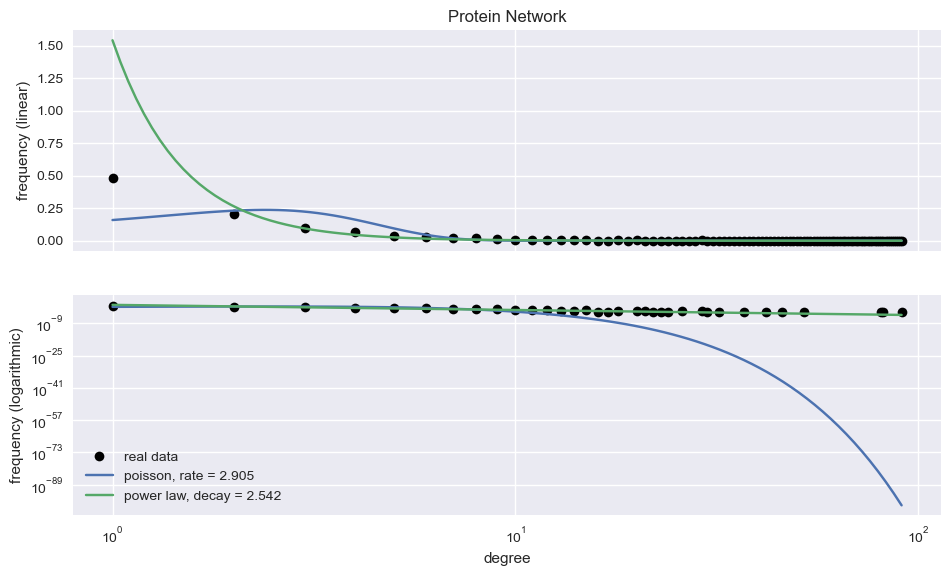

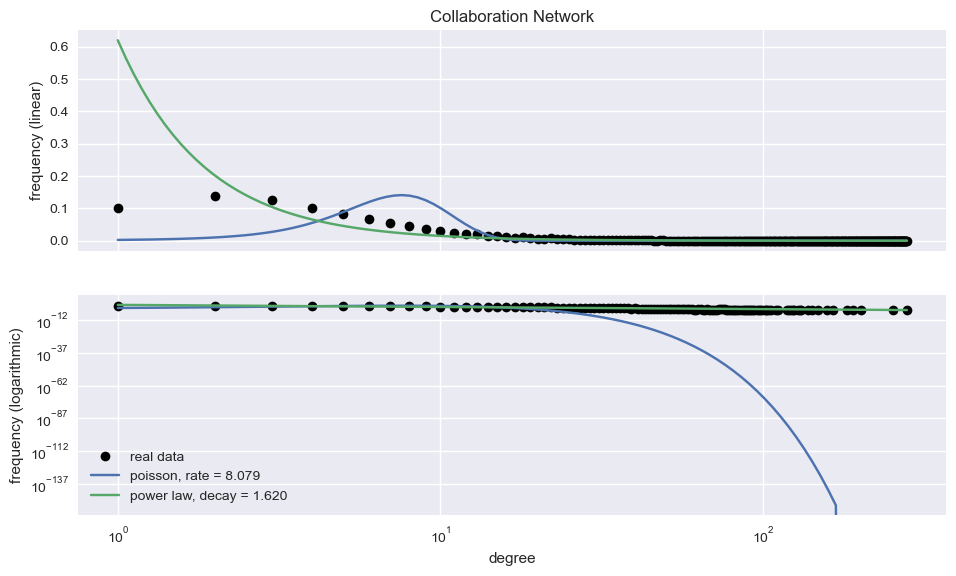

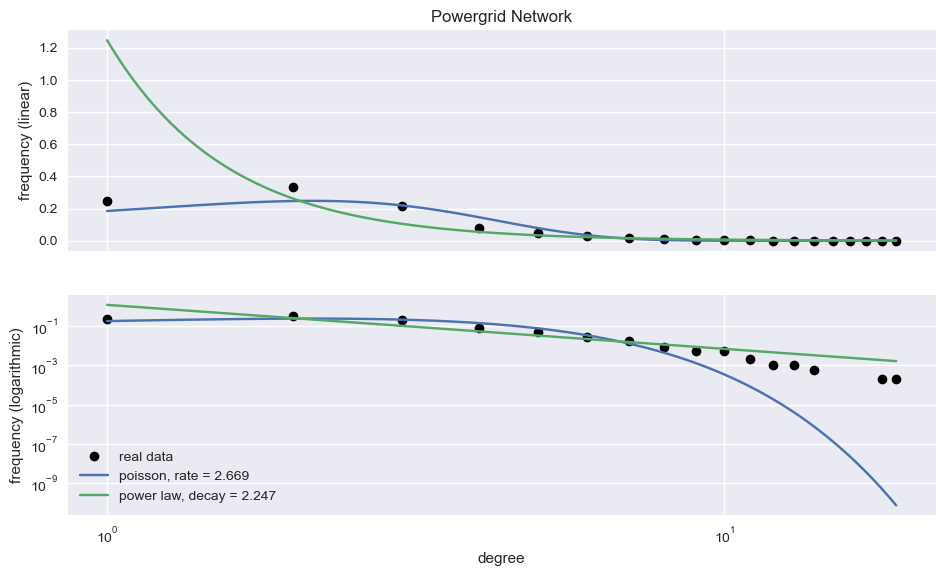

In [25]:
from scipy.special import gamma

min_degree = 1

def poisson(degree, rate):
    # poisson distribution
    return np.power(rate, degree) * np.exp(-rate) / gamma(degree+1)

def poisson_MLE(degrees):
    # maximum likelihood estimation for poisson distribution
    return np.mean(degrees)

def powerlaw(degree, decay, min_degree=1):
    # power law distribution
    return (decay-1) * np.power(min_degree, decay-1) * np.power(degree, -decay)

def powerlaw_MLE(degrees, min_degree=1):
    # maximum likelihood estimation for power law distribution
    return 1 + 1 / (np.mean(np.log(degrees)) - np.log(min_degree))

rates = dict()
decays = dict()

for name, network in networks.items():
    
    degrees = np.array(list(dict(network.degree).values()))
    histogram = np.array(nx.degree_histogram(network))[1:]
    frequencies = histogram / len(network)
    degree_range = np.arange(1, len(frequencies)+1, dtype=np.float64)
    degree_log = np.logspace(0, np.log10(len(frequencies)), 101)

    rate = poisson_MLE(degrees[min_degree:])
    rates[name] = rate
    poisson_vals = poisson(degree_log, rate)

    decay = powerlaw_MLE(degrees[min_degree:], min_degree)
    decays[name] = decay
    powerlaw_vals = powerlaw(degree_log, decay, min_degree)

    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

    ax1.semilogx(degree_range, frequencies, "ko")
    ax1.semilogx(degree_log, poisson_vals)
    ax1.semilogx(degree_log, powerlaw_vals)
    ax1.set_title(name)
    ax1.set_ylabel("frequency (linear)")

    ax2.loglog(degree_range, frequencies, "ko")
    ax2.loglog(degree_log, poisson_vals)
    ax2.loglog(degree_log, powerlaw_vals)
    ax2.set_xlabel("degree")
    ax2.set_ylabel("frequency (logarithmic)")

    plt.legend(["real data", f"poisson, rate = {rate:.3f}", f"power law, decay = {decay:.3f}"])
    plt.show()

*4. Write a function to compute the average next-nearest-neighbor degree.*

In [18]:
def average_next_nearest_degree(G):
    return np.sum(list(nx.average_neighbor_degree(G).values())) / len(G)

def moment(G, m=1):
    return np.sum(np.power(np.array(list(dict(G.degree).values())), m)) / len(G)

*5. Identify the friendship paradox.*

In [19]:
for name, network in networks.items():
    k = moment(network, m=1)
    k_nn = average_next_nearest_degree(network)
    print(f"{name:21}: <k_nn> = {k_nn:4.1f}, <k> = {k:.1f}, friendship paradox is {k_nn > k}")

Protein Network      : <k_nn> = 10.7, <k> = 2.9, friendship paradox is True
Collaboration Network: <k_nn> = 17.3, <k> = 8.1, friendship paradox is True
Powergrid Network    : <k_nn> =  4.0, <k> = 2.7, friendship paradox is True


*6. Compare with the analytical result from the paper exercise.*

In `networkx` the average next-nearest neighbor degree of node $i$ is defined as $k_{\mathrm{nn}}(i) = \frac{1}{k_i} \sum_{j \in N(i)} k_j$ and thus the average of the whole network as $\langle k_{\mathrm{nn}} \rangle = \frac{1}{N} \sum_{i=1}^N k_{\mathrm{nn}}(i)$ which differs from the definition we used in the analytical result. The conclusion of the friendship paradox stays the same for both the computational result and the analytical one. Printed below are also the results from the estimated distribution parameters from above.

In [31]:
for name, network in networks.items():
    computational = average_next_nearest_degree(network)
    formula = moment(network, m=2) / moment(network, m=1)
    poisson = rates[name] + 1
    decay = decays[name]
    max_degree = np.max(list(dict(network.degree).values()))
    powerlaw = (2-decay) / (3-decay) * (np.power(max_degree, 3-decay) - np.power(min_degree, 3-decay)) / (np.power(max_degree, 2-decay) - np.power(min_degree, 2-decay))
    print(f"{name:21}: computational {computational:4.1f}, formula {formula:4.1f}, poisson {poisson:3.1f}, power law {powerlaw:4.1f}")

Protein Network      : computational 10.7, formula 11.1, poisson 3.9, power law  8.9
Collaboration Network: computational 17.3, formula 22.1, poisson 9.1, power law 87.0
Powergrid Network    : computational  4.0, formula  3.9, poisson 3.7, power law  5.2
